# Hand Gesture Recognition #

### Import and Packages ###

In [1]:
# For working with Google Collab and files
#from google.colab import drive
#from google.colab import files
import os

# Model
from sklearn import tree
from sklearn.model_selection import train_test_split
from skimage.feature import ORB
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd


In [ ]:
# Mount Google Drive
# drive.mount('/content/gdrive')

## 1. Dataset Creation ##

In [17]:
base_path = 'gdrive/MyDrive/Colab Notebooks/Hand Gesture Recognition/leapGestRecog'

image_paths= []

for subdir, dirs, files in os.walk(base_path):
  for file in files:
      image_path = os.path.join(subdir, file)
      if image_path.endswith('.png'):
        image_paths.append(image_path)

In [ ]:
X = []
y = []

for path in image_paths:
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (320, 120))
    X.append(img)
    
    # Processing label in image path
    category = path.split("/")[6]
    label = int(category.split("_")[0][1])
    y.append(label)
    
X = np.array(X, dtype="uint8")
y = np.array(y)
print("Images loaded: ", len(X))
print("Labels loaded: ", len(y))

In [49]:
# Store the X and y array to .npy file for faster loading
# np.save('gdrive/MyDrive/Colab Notebooks/Hand Gesture Recognition/X.npy', X)
# np.save('gdrive/MyDrive/Colab Notebooks/Hand Gesture Recognition/y.npy', y)

In [2]:
# Load data from .npy file
X = np.load('X_full.npy')
y = np.load('y_full.npy')

## 2. Exploratory Data Analysis ##

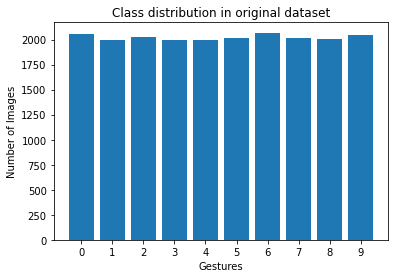

In [4]:
# Class Distribution for Original Dataset (Barplot)
(unique, counts) = np.unique(y, return_counts=True)

f, ax = plt.subplots()
plt.bar(unique, counts)
plt.title("Class distribution in original dataset")
plt.xlabel("Gestures")
plt.ylabel("Number of Images")
ax.set_xticks(unique)
ax.set_xticklabels(unique)

plt.show()

## 3. Feature Engineering ##

### I. Background Substitution / Gesture Enhancement ###

In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive')

In [ ]:
%cd '/content/gdrive/MyDrive'
!git clone https://github.com/Nkap23/background_removal_DL.git

In [ ]:
from cv2 import cv2 
from PIL import Image

In [ ]:
%cd '/content/gdrive/MyDrive/background_removal_DL/test_data/images'
!mkdir u2net_results

In [ ]:
%cd '/content/gdrive/MyDrive/background_removal_DL'
!python u2net_image.py

### II. Image Sharpening ###

In [5]:
# Function to create gaussian mask
def create_gaussian_mask(x, y, sigma=1):
    return np.exp(-((x**2 + y**2)/(2*sigma**2)))

# Function to apply Gaussian Filters 
def apply_gaussian_filter(mask_size, sigma=1):
    i = -mask_size//2 + 1
    j = mask_size//2 + 1
    x,y = np.mgrid[i:j, i:j]
    gaussain_mask = create_gaussian_mask(x,y,sigma)
    return gaussain_mask/gaussain_mask.sum()

def sharpen_image(img):
  # Smoothing 
  k3_3 = apply_gaussian_filter(3,1)
  smoothen_img = cv2.filter2D(img,-1,k3_3, borderType=cv2.BORDER_CONSTANT)  

  # Sharpening
  return np.subtract(img, smoothen_img) 


### III. Edge Detection ###

In [6]:
def apply_hor_filter(img):
  # Horizontal Edge detection Kernal - Purpose is to detect horizontal edge in the image
  hor_filter = np.array([[ 1, 1, 1],                        
                    [ 0, 0, 0],
                    [ -1, -1, -1]])
  return cv2.filter2D(img,-1,hor_filter, borderType=cv2.BORDER_CONSTANT)   

def apply_ver_filter(img):
  # Vertical Edge detection Kernal - Purpose is to detect vertical edge in the image
  ver_filter = np.array([[ 1, 0, -1],                        
                    [ 1, 0, -1],
                    [ 1, 0, -1]])
  return cv2.filter2D(img,-1,ver_filter, borderType=cv2.BORDER_CONSTANT)   

### IV. Key Point Detection ###

In [7]:
def detect_key_points(img):
    # Extract Keypoints
    extractor = ORB(n_keypoints=20)
    extractor.detect_and_extract(img)
    return extractor.keypoints


### V. Harris Corner Detection ###

In [8]:
def apply_harris_corner_detection(img):
  gray = np.float32(img)
  return cv2.cornerHarris(gray,2,3,0.04)

### VI. Generate Features ###

In [9]:
# 1. Image Sharpening
sharpen_imgs = [ sharpen_image(img) for img in X]

# 2.a Vertical Edges
vertical_edges = [ apply_ver_filter(sharpen_img) for sharpen_img in sharpen_imgs]

# 2.b Horizontal Edges
horizontal_edges = [ apply_hor_filter(sharpen_img) for sharpen_img in sharpen_imgs]

# 3. Key Points Detection
#key_points = [ detect_key_points(sharpen_img) for sharpen_img in sharpen_imgs]

# 4. Harris Corner Detection
harris_corners = [ apply_harris_corner_detection(sharpen_img) for sharpen_img in sharpen_imgs]


In [10]:
# Integrating all the features 
X_final = []
for row_index in range(len(X)):
  X_final.append(np.hstack((np.array(vertical_edges[row_index]).flatten(), np.array(horizontal_edges[row_index]).flatten(), np.array(harris_corners[row_index]).flatten())))

## 4. Split Dataset into train and test ##

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.3, random_state=200)

## 5. Create and Train model ##

In [12]:
# Creating Decision Tree model
d_tree = tree.DecisionTreeClassifier()

# Training the model
clf = d_tree.fit(X_train, y_train)

## 6. Evaluate Model ##

In [13]:
# Making prediction for testing data
y_pred = clf.predict(X_test)

In [14]:
# Calculating accuracy score
metrics.accuracy_score(y_test, y_pred)

0.6164992590153137

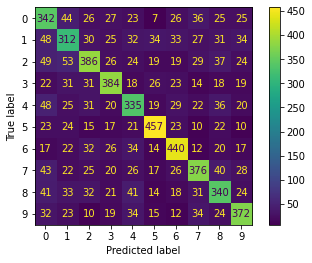

In [15]:
# Plotting Confusion Matrix
plot_confusion_matrix(clf, X_test, y_test) 
plt.show()

## 7. Predict Gesture ##